# Messing with the vgg16 features/ making superclass files
Use this notebook to do things with the VGG16 features and to make superclass definitions

In [2]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]=""
import VGG16base
import tensorflow as tf
import cifar10_input_VGG16 as cifarin
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy
import pickle
import sys
sys.path.insert(0, '//code/bhtsne')
import bhtsne

from sklearn.decomposition import PCA

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo)
    return dict

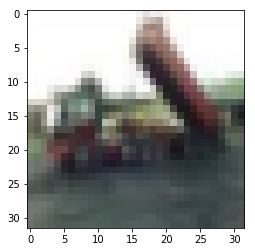

In [3]:
d = unpickle('//code/logs/cifar10_pydata/cifar-10-batches-py/data_batch_1')
data = d['data']
data = data.reshape(10000,3,32,32).transpose(0,2,3,1)
plt.imshow(data[2].astype(np.uint8),vmin=0,vmax=255,aspect='equal', interpolation='none')
plt.show()

In [11]:
#preproccess data
VGG_MEAN = [103.939, 116.779, 123.68]
with tf.Session() as sess:
    images = tf.placeholder(tf.float32,(None,32,32,3))
    predata = tf.image.resize_images(images,tf.constant((224,224)))
    red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=predata)
    assert red.get_shape().as_list()[:] == [None,224, 224, 1]
    assert green.get_shape().as_list()[:] == [None,224, 224, 1]
    assert blue.get_shape().as_list()[:] == [None,224, 224, 1]
    bgr = tf.concat(axis=3, values=[
        blue - VGG_MEAN[0],
        green - VGG_MEAN[1],
        red - VGG_MEAN[2],
    ])
    
    vgg = VGG16base.Vgg16('//code/vgg16.npy')
    vgg.build(bgr)
    
    sess.run(tf.global_variables_initializer())
    
    feats = []
    for f in range(1,6):
        data = unpickle('//code/logs/cifar10_pydata/cifar-10-batches-py/data_batch_' + str(f))['data']
        data = data.reshape(10000,3,32,32).transpose(0,2,3,1)
        for i in range(100):
            if len(feats)==0:
                feats = np.reshape(sess.run(vgg.fc8, feed_dict={images:data[100*i:100*(i+1)]}),(100,-1))
            else:
                feats = np.vstack([feats,np.reshape(sess.run(vgg.pool5, feed_dict={images:data[100*i:100*(i+1)]}),(100,-1))])

build model started
Tensor("pool5_2:0", shape=(?, 7, 7, 512), dtype=float32)
build model finished: 0s


In [10]:
unpickle('//code/logs/cifar10_pydata/cifar-10-batches-py/data_batch_1perc_skip')

IOError: [Errno 2] No such file or directory: '//code/logs/cifar10_pydata/cifar-10-batches-py/data_batch_1perc_skip'

In [8]:
labels = np.array([])
for f in range(1,6):
        labels = np.hstack([labels,unpickle('//code/logs/cifar10_pydata/cifar-10-batches-py/data_batch_' + str(f))['labels']])


IOError: [Errno 2] No such file or directory: '//code/logs/cifar10_pydata/cifar-10-batches-py/data_batch_1perc_skip'

In [7]:
with open('//code/logs/cifar10labels.pkl','wb') as f:
    pickle.dump(labels,f)

In [8]:
with open('//code/logs/cifarVGGfc8trainfeats.pkl','wb') as f:
    pickle.dump(feats,f)

### TSNE visualisation

In [ ]:
with open('//code/logs/feats_pca.pkl','rb') as f:
    tsned = pickle.load(f)

In [ ]:
cconv=np.array(['r','g','b','y','orange','black','w','grey','brown','pink'])

In [ ]:
plt.figure(figsize=[50,50])
plt.scatter(tsned[:,0],tsned[:,1],c=cconv[np.array(d['labels'])])

In [ ]:
d.keys()

In [ ]:
with open('//code/logs/cifarVGGfc7trainfeats.pkl','rb') as f:
    feats = pickle.load(f)

In [ ]:
pca = PCA(n_components=2048)
pcaFeats = pca.fit_transform(feats)

In [ ]:
print(np.sum(pca.explained_variance_ratio_))
print(pca.components_)

In [ ]:
plt.figure(figsize=[50,50])
plt.scatter(pcaFeats[:,0],pcaFeats[:,1],c=cconv[np.array(d['labels'])])

## Generate superclass split

In [ ]:
from sklearn.cluster import KMeans
km = KMeans(2)
split = km.fit_predict(tsned)

In [ ]:
cconv = np.array(['r','b'])
plt.figure(figsize=[50,50])
plt.scatter(tsned[:,0],tsned[:,1],c=cconv[np.array(split)])

In [ ]:
with open('//code/logs/superclass_tsne_pool5.pkl','wb') as f:
    pickle.dump(split,f)

In [ ]:
print(split[split==0].shape,' || ',split[split==1].shape)

# kmeans total fc7 & pool5

In [ ]:
with open('//code/logs/cifarVGGfc7trainfeats.pkl','rb') as f:
    feats = pickle.load(f)

In [ ]:
from sklearn.cluster import KMeans
km = KMeans(2)
split = km.fit_predict(feats)

In [ ]:
with open('//code/logs/superclass_plain_fc7.pkl','wb') as f:
    pickle.dump(split,f)

In [ ]:
with open('//code/logs/cifarVGGpool5trainfeats.pkl','rb') as f:
    feats = pickle.load(f)

In [12]:
feats.shape

(50000, 25088)

In [10]:
from sklearn.cluster import KMeans
km = KMeans(2)
split = km.fit_predict(feats)

In [11]:
with open('//code/logs/superclass_plain_pool5.pkl','wb') as f:
    pickle.dump(split,f)

# blue threshold

In [39]:
blueness = np.reshape(np.array([]),[0,1])
for f in range(1,6):
    data = unpickle('//code/logs/cifar10_pydata/cifar-10-batches-py/data_batch_' + str(f))['data']
    data = data.reshape(10000,3,32,32).transpose(0,2,3,1)
    #print(blueness.shape)
    #print(np.mean(np.mean(data[:,:,:,2],1),1).shape)
    blueness = np.vstack([blueness,np.reshape(np.mean(np.mean(data[:,:,:,2],1),1),[10000,1])])

In [44]:
print(blueness.shape)
blueness = np.reshape(blueness,[50000])
print(blueness.shape)

(50000, 1)
(50000,)


In [45]:
med = np.median(blueness)
print(med)
split = np.array(blueness<med,dtype='int32')
print(split.shape)
print(split[:100])

111.061523438
(50000,)
[1 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 1 1 0
 1 0 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1
 0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1]


In [47]:
with open('//code/logs/superclass_blueness.pkl','wb') as f:
    pickle.dump(split,f)

# Checking the subclasses

In [13]:
with open('//code/logs/superclass_blueness.pkl','rb') as f:
    superclasslab = pickle.load(f)

In [6]:
with open('//code/logs/cifar10labels.pkl','rb') as f:
    labels = pickle.load(f)

In [14]:
np.unique(labels[superclasslab==0],return_counts = True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 array([4123, 2517, 2054, 2107, 1485, 2048, 1166, 2084, 4190, 3227]))

In [15]:
np.unique(labels[superclasslab==1],return_counts = True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 array([ 877, 2483, 2946, 2893, 3515, 2952, 3834, 2916,  810, 1773]))